In [110]:
import numpy as np
from scipy.spatial import Delaunay
import cv2
import dlib
import random

import matplotlib.pyplot as plt
from matplotlib import path

%matplotlib inline

## 1 Correspondence

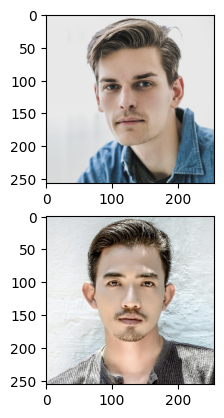

In [6]:
src_image = plt.imread('portrait0.jpeg')
dst_image = plt.imread('portrait1.jpeg')

src_image = cv2.resize(src_image, (256, 256))
dst_image = cv2.resize(dst_image, (256, 256))

fig, ax = plt.subplots(2, 1)
ax[0].imshow(src_image)
ax[1].imshow(dst_image)


In [100]:
def getShapePoints(img):

    height, width, c = img.shape

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    rects = detector(img, 0)
    shape = predictor(img, rects.pop())
    
    shape_array = [[0, 0], [0, width], [height, 0], [height, width]]
    for i in range(68):
        pt = shape.part(i)
        shape_array.append([pt.x, pt.y])
    shape_array = np.array(shape_array)

    return shape_array

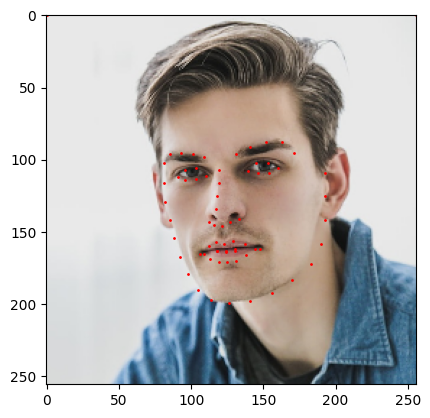

In [101]:
shape_src = getShapePoints(src_image)
plt.plot(shape_src[:, 0], shape_src[:, 1], 'ro', markersize=1)
plt.imshow(src_image)
plt.show()

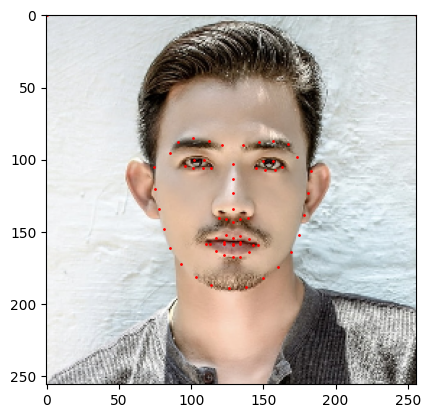

In [102]:
shape_dst = getShapePoints(dst_image)
plt.plot(shape_dst[:, 0], shape_dst[:, 1], 'ro', markersize=1)
plt.imshow(dst_image)
plt.show()

## 2 Mesh

In [103]:
def getDelaunayTriMesh(points):
    return Delaunay(points).simplices

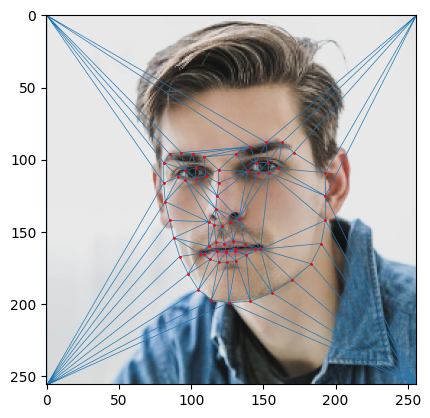

In [104]:
tri_src = getDelaunayTriMesh(shape_src)

plt.triplot(shape_src[:, 0], shape_src[:, 1], tri_src, linewidth=0.5)
plt.plot(shape_src[:,0], shape_src[:,1], 'ro', markersize=1) 
plt.imshow(src_image)
plt.show()

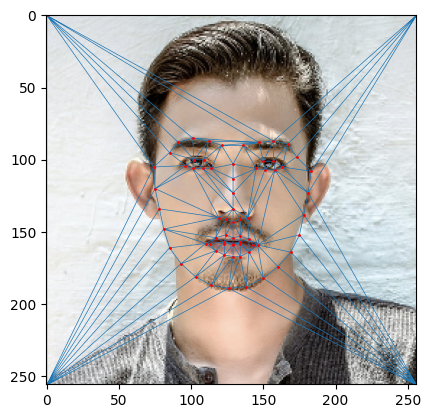

In [105]:
plt.triplot(shape_dst[:, 0], shape_dst[:, 1], tri_src, linewidth=0.5)
plt.plot(shape_dst[:,0], shape_dst[:,1], 'ro', markersize=1) 
plt.imshow(dst_image)
plt.show()

## 3 Blending with a mesh

In [75]:
def calAffineMat(tri_src, tri_dst):

    assert tri_src.shape == (3, 2) and tri_dst.shape == (3, 2)

    tri_src = np.hstack((tri_src, np.array([[1],[1],[1]]))).T
    tri_dst = np.hstack((tri_dst, np.array([[1],[1],[1]]))).T

    affineMat = tri_dst @ np.linalg.inv(tri_src)
    affineMat[2] = np.array([0., 0., 1.])

    return affineMat

In [ ]:
def bilinearInterpolation(im, point):
    Q11 = np.floor(point).astype(np.uint32)
    Q12 = Q11 + np.array([0, 1])
    Q22 = Q11 + np.array([1, 1])
    Q21 = Q11 + np.array([1, 0])

    fQ = np.array([
        [im[Q11], im[Q12]],
        [im[Q21], im[Q22]]
    ])
    x = np.array([
        [Q21[0] - point[0], point[0] - Q11[0]],
    ])
    y = np.array([
        [Q21[1] - point[1], point[1] - Q11[1]],
    ]).T

    return x @ fQ @ y / (np.sum(x) * np.sum(y))

In [148]:
def inTriangle(point, triangle):
    
    assert point.shape == (2,) and triangle.shape == (3, 2)
    return path.Path(triangle).contains_points([point], radius=1e-8)[0]

In [ ]:
def calBetweenImage(im_src, im_dst, w):
    